In [52]:
import numpy as np
import csv
import matplotlib.pyplot as plt

# Load data

In [53]:
fields = {
    'Marital status',
    'Application mode',
    'Application order',
    'Course',
    'Daytime/evening attendance\t',
    'Previous qualification',
    'Previous qualification (grade)',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Admission grade',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'Age at enrollment',
    'International',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate',
    'Inflation rate',
    'GDP',
}

def load_student_data(path_data='data/student-dropout/data.csv'):
    '''
    Load dataset and remove 'Enrolled' target
    '''
    data = []
    with open(path_data, encoding='utf-8-sig') as f_data:
        for datum in csv.DictReader(f_data, delimiter=';'):
            remove = False
            for field in list(datum.keys()):
                if field in fields and datum[field]:
                    datum[field] = float(datum[field])
                if field == 'Target':
                    if datum[field] == 'Enrolled':
                        remove = True
                    elif datum[field] == 'Dropout':
                        datum[field] = -1.
                    else: # 'Graduated'
                        datum[field] = 1.
            if not remove: 
                data.append(datum)
    return data

In [54]:
student_data = load_student_data()
print('Number of examples:', len(student_data))
# print('An example:')
# student_data[100]

Number of examples: 3630


## Feature transforms

In [55]:
def std_vals(data, f):
    vals = [entry[f] for entry in data]
    avg = sum(vals) / len(vals)
    dev = [(entry[f] - avg)**2 for entry in data]
    sd = (sum(dev) / len(vals))**0.5
    return avg, sd

In [56]:
def standard(v, std):
    return [(v - std[0]) / std[1]]

In [57]:
def raw(x):
    return [x]

In [58]:
def one_hot(v, entries):
    '''
    v -- value
    entries -- possible values
    '''
    vec = len(entries) * [0]
    vec[entries.index(v)] = 1
    return vec

## Preprocess data

In [59]:
features = [
    ('Marital status', one_hot),
    ('Application mode', one_hot),
    ('Application order', raw),
    ('Course', one_hot),
    ('Daytime/evening attendance\t', raw),
    ('Previous qualification', one_hot),
    ('Previous qualification (grade)', standard),
    ('Nacionality', one_hot),
    ("Mother's qualification", one_hot),
    ("Father's qualification", one_hot),
    ("Mother's occupation", one_hot),
    ("Father's occupation", one_hot),
    ('Admission grade', standard),
    ('Displaced', raw),
    ('Educational special needs', raw),
    ('Debtor', raw),
    ('Tuition fees up to date', raw),
    ('Gender', raw),
    ('Scholarship holder', raw),
    ('Age at enrollment', raw),
    ('International', raw),
    ('Curricular units 1st sem (credited)', raw),
    ('Curricular units 1st sem (enrolled)', raw),
    ('Curricular units 1st sem (evaluations)', raw),
    ('Curricular units 1st sem (approved)', raw),
    ('Curricular units 1st sem (grade)', raw),
    ('Curricular units 1st sem (without evaluations)', raw),
    ('Curricular units 2nd sem (credited)', raw),
    ('Curricular units 2nd sem (enrolled)', raw),
    ('Curricular units 2nd sem (evaluations)', raw),
    ('Curricular units 2nd sem (approved)', raw),
    ('Curricular units 2nd sem (grade)', raw),
    ('Curricular units 2nd sem (without evaluations)', raw),
    ('Unemployment rate', standard),
    ('Inflation rate', standard),
    ('GDP', standard),
]

In [60]:
def preprocess(data, features, verbose=True):
    features = [('Target', raw)] + features
    std = {f : std_vals(data, f) \
           for (f,phi) in features if phi == standard}
    entries = {f : list(set([entry[f] for entry in data])) \
               for (f, phi) in features if phi == one_hot} 
    if verbose: print('Mean and Std:', std)
    if verbose: print('Entries in one_hot field:', entries)
    
    findex = 0
    # Print the meaning of features
    for (f, phi) in features[1:]: # skip 'Target'
        if phi == standard:
            if verbose: print(findex, f, 'std')
            findex += 1
        elif phi == one_hot:
            for entry in entries[f]:
                if verbose: print(findex, f, entry, 'one_hot')
                findex += 1
        else:
            if verbose: print(findex, f, 'raw')
            findex += 1

    vals = []
    for entry in data:
        phis = []
        for (f, phi) in features:
            if phi == standard:
                phis.extend(phi(entry[f], std[f]))
            elif phi == one_hot:
                phis.extend(phi(entry[f], entries[f]))
            else:
                phis.extend(phi(entry[f]))
        vals.append(np.array([phis])) # phis of shape (1,D)
    
    data = np.vstack(vals)
    np.random.seed(0)
    np.random.shuffle(data)
    return data[:, 1:], data[:, 0:1]


In [61]:
X, y = preprocess(student_data, features, verbose=True)
print('\nData shape:', X.shape)
print('Labels shape:', y.shape)

Mean and Std: {'Previous qualification (grade)': (132.92060606060494, 13.236549060750294), 'Admission grade': (127.29393939393924, 14.609282556743532), 'Unemployment rate': (11.63035812672188, 2.667284425747152), 'Inflation rate': (1.2315977961432394, 1.3847204104409045), 'GDP': (-0.009256198347107725, 2.259674553698473)}
Entries in one_hot field: {'Marital status': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0], 'Application mode': [1.0, 2.0, 5.0, 39.0, 7.0, 42.0, 43.0, 44.0, 10.0, 15.0, 16.0, 17.0, 18.0, 51.0, 53.0, 57.0, 26.0, 27.0], 'Course': [33.0, 9254.0, 9991.0, 9670.0, 9130.0, 171.0, 9003.0, 9773.0, 8014.0, 9070.0, 9085.0, 9556.0, 9238.0, 9147.0, 9500.0, 9853.0, 9119.0], 'Previous qualification': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 39.0, 40.0, 9.0, 10.0, 42.0, 12.0, 43.0, 38.0, 15.0, 14.0, 19.0], 'Nacionality': [1.0, 2.0, 6.0, 11.0, 13.0, 14.0, 17.0, 21.0, 22.0, 24.0, 25.0, 26.0, 41.0, 62.0, 100.0, 101.0, 103.0, 105.0, 109.0], "Mother's qualification": [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 10.0, 11.0

## Train/Test split

In [63]:
def random_split(data, labels, test_pct=0.2, seed=None):
    if seed and isinstance(seed, int):
        np.random.seed(seed)
    n, d = data.shape
    idxs = np.random.permutation(n)
    split_pt = int((1 - test_pct) * n)
    train_idxs, test_idxs = idxs[:split_pt], idxs[split_pt:]
    X_train, y_train = data[train_idxs, :], labels[train_idxs, :]
    X_test, y_test = data[test_idxs, :], labels[test_idxs, :]
    return X_train, y_train, X_test, y_test

In [64]:
def stratified_split(data, labels, test_pct=0.2, seed=None):
    if seed and isinstance(seed, int):
        np.random.seed(seed)
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    test_label_counts = (label_counts * test_pct).astype(int)
    train_label_counts = label_counts - test_label_counts
    train_idxs, test_idxs = [], []
    for label, train_count, test_count in zip(unique_labels, train_label_counts, test_label_counts):
        label_idxs = np.where(labels == label)[0] # return an array of indexes
        permuted_idxs = np.random.permutation(label_idxs)
        train_idxs.extend(permuted_idxs[:train_count])
        test_idxs.extend(permuted_idxs[train_count:])
    X_train, y_train = data[train_idxs], labels[train_idxs]
    X_test, y_test = data[test_idxs], labels[test_idxs]
    return X_train, y_train, X_test, y_test

In [65]:
# X_train, y_train, X_test, y_test = random_split(X, y)
X_train, y_train, X_test, y_test = stratified_split(X, y)

Train labels:
  -1.0 appears 1137 times - 39.14%
  1.0 appears 1768 times - 60.86%
Test labels:
  -1.0 appears 284 times - 39.17%
  1.0 appears 441 times - 60.83%


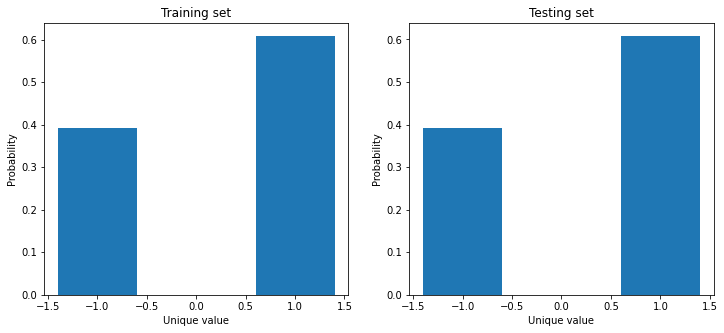

In [66]:
def value_counts(y):
    vals, cnts = np.unique(y, return_counts=True)
    probs = cnts / np.sum(cnts)
    for value, count, prob in zip(vals, cnts, probs):
        print(f"  {value} appears {count} times - {prob*100:.2f}%")
    return vals, cnts, probs

print('Train labels:')
train_vals, train_cnts, train_probs = value_counts(y_train)
print('Test labels:')
test_vals, test_cnts, test_probs = value_counts(y_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
ax1.bar(train_vals, train_probs)
ax1.set_title("Training set")
ax1.set_xlabel("Unique value")
ax1.set_ylabel("Probability")

ax2.bar(test_vals, test_probs)
ax2.set_title("Testing set")
ax2.set_xlabel("Unique value")
ax2.set_ylabel("Probability")

# plt.savefig('images/strat_split.png')
plt.show()

In [67]:
# split train set again to attain new train set and validation set
X_dev, y_dev, X_val, y_val = stratified_split(X_train, y_train)

# Metrics

Using Laplace smoothing

In [68]:
# Calculate accuracy
def accuracy(y_pred, y_true):
    return np.sum(y_true == y_pred) / len(y_true)

# Calculate precision
def precision(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    k = len(class_labels)
    precision_scores = []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FP = np.sum(np.logical_and(y_pred == label, y_true != label))
        precision = (TP + 1e-8) / (TP + FP + 1e-8 * k)
        precision_scores.append(precision)
    average_precision = np.mean(precision_scores)
    return average_precision

# Calculate recall
def recall(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    k = len(class_labels)
    recall_scores = []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FN = np.sum(np.logical_and(y_pred != label, y_true == label))
        recall = (TP + 1e-8) / (TP + FN + 1e-8 * k)
        recall_scores.append(recall)
    average_recall = np.mean(recall_scores)
    return average_recall

# Calculate F1 score
def f1(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    k = len(class_labels)
    f1_scores = []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FP = np.sum(np.logical_and(y_pred == label, y_true != label))
        FN = np.sum(np.logical_and(y_pred != label, y_true == label))
        precision = (TP + 1e-8) / (TP + FP + 1e-8 * k)
        recall = (TP + 1e-8) / (TP + FN + 1e-8 * k)
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)
    average_f1 = np.mean(f1_scores)
    return average_f1

# Confusion matrix
def confusion_matrix(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    TPs, FPs, FNs, TNs = [], [], [], []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FP = np.sum(np.logical_and(y_pred == label, y_true != label))
        FN = np.sum(np.logical_and(y_pred != label, y_true == label))
        TN = np.sum(np.logical_and(y_pred != label, y_true != label))
        TPs.append(TP)
        FPs.append(FP)
        FNs.append(FN)
        TNs.append(TN)
    return np.array([[int(np.mean(TPs)), int(np.mean(FPs))], [int(np.mean(FNs)), int(np.mean(TNs))]])

# Models

## Decision Tree

In [69]:
# Decision tree node class
class DTNode:
    N_THRESHOLD = 4 # don't split if node has fewer examples than this
    H_THRESHOLD = .01 # don't split if node has entropy less than this
    H_REDUCTION_THRESHOLD = .001 # don't split if entropy reduction is less than this
    MAX_DEPTH = 10
    index = 0

    def __init__(self, data=None, config=None, depth=0):
        self.config = config
        self.depth = depth
        if config != None:
            self.N_THRESHOLD = config[0]
            self.H_THRESHOLD = config[1]
            self.H_REDUCTION_THRESHOLD = config[2]
            self.MAX_DEPTH = config[3]
        
        DTNode.index += 1
        self.index = DTNode.index # node has unique number
        self.data = data
        self.prob = None
        if data is not None:
            self.n = float(data.shape[0]) # number of examples
            self.indices = range(data.shape[1] - 1) # feature indices
            self.set_h()

        self.splits = {}

        self.feat_id = None # feature index
        self.thres = None # threshold
        self.lchild = None # left child
        self.rchild = None # right child
        self.parent = None

    # Create split on feature 'i' at value 'th'
    def split(self, i, th):
        self.feat_id = i
        self.thres = th
        self.lchild = DTNode(self.data[self.data[:, i] < th], self.config)
        self.rchild = DTNode(self.data[self.data[:, i] >= th], self.config)
        self.splits[i].remove(th)

    # Evaluate candidate split by weighted average entropy
    def split_eval(self, i, th):
        lc = DTNode(self.data[self.data[:, i] < th], self.config, self.depth + 1)
        rc = DTNode(self.data[self.data[:, i] >= th], self.config, self.depth + 1)
        pl = lc.n / self.n
        pr = 1.0 - pl
        avgH = pl * lc.H + pr * rc.H
        return avgH, lc, rc
    
    # Entropy of class labels in this node, assumes 1, -1
    def set_h(self):
        b = .001
        npos = np.sum(self.data[:,-1] == 1) # count labels 1
        p = (npos + b) / (self.n + b + b)
        self.prob = p
        self.H = -p * np.log(p) - (1-p) * np.log(1-p)

    def build_tree(self):
        if self.H < self.H_THRESHOLD or self.n <= self.N_THRESHOLD:
            return
        if self.depth >= self.MAX_DEPTH:
            return
        # Find the best split
        (i, th, (h, lc, rc)) = argmax([(i, th, self.split_eval(i, th)) \
                                            for i in self.indices \
                                            for th in self.get_splits(i)],
                                        lambda x : -x[2][0]) # x = (a, b, (h, c, d))
        
        if (self.H - h) < self.H_REDUCTION_THRESHOLD:
            return
        
        
        # Recurse
        self.feat_id = i
        self.thres = th
        self.lchild = lc
        self.rchild = rc
        self.lchild.parent = self
        self.rchild.parent = self
        self.lchild.build_tree()
        self.rchild.build_tree()
    
    # Sort examples and return middle points between every two consecutive samples
    def get_splits(self, i):
        if i not in self.splits:
            # d = np.sort(np.unique(self.data[:,i]), axis=None)
            # d1 = d[:-1]
            # d2 = d[1:]
            # self.splits[i] = (d1 + d2) / 2.0
            self.splits[i] = np.sort(np.unique(self.data[:,i]), axis=None)
        return self.splits[i]

    # Classify a data point
    def classify(self, x):
        if self.feat_id == None: # leaf node
            return self.prob
        elif x[self.feat_id] < self.thres:
            return self.lchild.classify(x) # go to left child
        else:
            return self.rchild.classify(x) # go to right child
        
    def display(self, depth=0, max_depth=3):
        if depth > max_depth:
            print(depth*'  ', 'Depth >', max_depth)
        if self.feat_id is None:
            print(depth*'  ', '=>', '%.2f'%self.prob, '[ n=', self.n, ']')
            return
        print(depth*'  ', 'Ft.', self.feat_id, '<', '%.2f'%self.thres, '[ n=', self.n, ']')
        self.lchild.display(depth+1, max_depth)
        self.rchild.display(depth+1, max_depth)

def argmax(l, f):
    """
    Return the element in list l that gives highest value on f

    @param l: C{List} of items
    @param f: C{Procedure} that maps an item into a numeric score
    @returns: the element of C{l} that has the highest score
    """
    vals = [f(x) for x in l]
    return l[vals.index(max(vals))]

In [70]:
class DecisionTree:
    def fit(self, X, Y, config=None):
        D = np.hstack([X,Y])
        self.root = DTNode(D, config)
        self.root.build_tree()
    def predict(self, X):
        pred = np.array([np.apply_along_axis(self.root.classify, 1, X)]).T - 0.5
        pred[pred >= 0] = 1
        pred[pred < 0] = -1
        return pred
    def display(self, depth=0, max_depth=3):
        self.root.display(depth, max_depth)

## Bagging

In [71]:
class Bagging:
    def __init__(self, num_trees=5):
        self.ntrees = num_trees
        self.trees = []
    def fit(self, X, Y, config=None):
        for i in range(self.ntrees):
            idxs = np.random.choice(len(X), size=len(X), replace=True)
            X_train = X[idxs, :]
            Y_train = Y[idxs, :]
            dt = DecisionTree()
            dt.fit(X_train, Y_train, config)
            self.trees.append(dt)
    def predict(self, X):
        preds = []
        if len(self.trees) == 0: return None
        for dt in self.trees:
            pred = dt.predict(X)
            preds.append(pred)
        preds = np.hstack(preds)
        return np.sign(preds.mean(axis=1, keepdims=True))

## Random Forest

In [72]:
class RandomForest:
    def __init__(self, num_trees=5, num_features=None):
        self.ntrees = num_trees
        self.nfeats = num_features
        self.trees = []
        self.feats = []
    
    def fit(self, X, Y, config=None):
        for i in range(self.ntrees):
            idxs = np.random.choice(len(X), size=len(X), replace=True)
            if self.nfeats is not None:
                features = np.random.choice(X.shape[1], size=self.nfeats, replace=False)
                X_train = X[idxs][:, features]
                self.feats.append(features)
            else:
                X_train = X[idxs]
            Y_train = Y[idxs]
            dt = DecisionTree()
            dt.fit(X_train, Y_train, config)
            self.trees.append(dt)
    
    def predict(self, X):
        preds = []
        if len(self.trees) == 0:
            return None
        for i in range(len(self.trees)):
            dt = self.trees[i]
            if self.nfeats is not None:
                features = self.feats[i]
                X_test = X[:, features]
            else:
                X_test = X
                
            pred = dt.predict(X_test)
            preds.append(pred)
        preds = np.hstack(preds)
        return np.sign(np.mean(preds, axis=1, keepdims=True))

In [73]:
def evaluate(model_class, X_train, Y_train, X_test, Y_test, max_depth=5, verbose=True, config=None, args=None):
    if args:
        model = model_class(*args)
    else:
        model = model_class()
    model.fit(X_train, Y_train, config)
    pred_test = model.predict(X_test)
    acc_s = accuracy(pred_test, Y_test)
    prec_s = precision(pred_test, Y_test)
    rec_s = recall(pred_test, Y_test)
    f1_s = f1(pred_test, Y_test)
    if verbose:
        print(f'  Accuracy  : {acc_s:.5f}')
        print(f'  Precision : {prec_s:.5f}')
        print(f'  Recall    : {rec_s:.5f}')
        print(f'  F1        : {f1_s:.5f}')
        if isinstance(model, DecisionTree): 
            model.display(max_depth=max_depth)
    return acc_s, prec_s, rec_s, f1_s

In [22]:
def cross_validate(data, labels, k=10, model='DecisionTree', verbose=True, config=None, args=None):
    if model == 'Bagging':
        model_class = Bagging
    elif model == 'RandomForest':
        model_class = RandomForest
    else:
        model_class = DecisionTree
    indices = np.random.permutation(data.shape[0])
    X = data[indices,:]
    Y = labels[indices,:]
    s_data = np.array_split(X, k, axis=0)
    s_labels = np.array_split(Y, k, axis=0)
    acc_s = 0.
    prec_s = 0.
    rec_s = 0.
    f1_s = 0.
    for i in range(k):
        X_train = np.concatenate(s_data[:i] + s_data[i+1:], axis=0)
        Y_train = np.concatenate(s_labels[:i] + s_labels[i+1:], axis=0)
        X_test = np.array(s_data[i])
        Y_test = np.array(s_labels[i])
        if verbose == "first_tree":
            if i == 0:
                acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=True, config=config, args=args)
            else:
                acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=False, config=config, args=args)
        elif verbose == True:
            print('Round',i+1)
            acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=True, config=config, args=args)
        else:
            acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=False, config=config, args=args)
        acc_s += acc
        prec_s += prec
        rec_s += rec
        f1_s += f1
    print('\nCROSS VALIDATION RESULTS:')
    print(f'- Avg. Accuracy  : {acc_s/k:.5f}')
    print(f'- Avg. Precision : {prec_s/k:.5f}')
    print(f'- Avg. Recall    : {rec_s/k:.5f}')
    print(f'- Avg. F1        : {f1_s/k:.5f}')
    return acc_s/k, prec_s/k, rec_s/k, f1_s/k

# cross_validate(X_train, y_train, k=5, verbose=True, config=[4, .01, .001, 3])
cross_validate(X_train, y_train, model='RandomForest', k=5, verbose=True, args=[10, 200])
# cross_validate(X_train, y_train, model='Bagging', k=5, verbose=True, args=[7])


Round 1
  Accuracy  : 0.90361
  Precision : 0.91922
  Recall    : 0.88797
  F1        : 0.90143
Round 2
  Accuracy  : 0.87435
  Precision : 0.91706
  Recall    : 0.85933
  F1        : 0.88323
Round 3
  Accuracy  : 0.90189
  Precision : 0.91536
  Recall    : 0.88610
  F1        : 0.89902
Round 4
  Accuracy  : 0.90361
  Precision : 0.92300
  Recall    : 0.89070
  F1        : 0.90482
Round 5
  Accuracy  : 0.88468
  Precision : 0.92538
  Recall    : 0.86716
  F1        : 0.89090

CROSS VALIDATION RESULTS:
- Avg. Accuracy  : 0.89363
- Avg. Precision : 0.92001
- Avg. Recall    : 0.87825
- Avg. F1        : 0.89588


(0.893631669535284, 0.9200055399441547, 0.8782505832441372, 0.8958808017780345)

# Plotting

## For decision tree

In [107]:
max_depths = np.arange(1, 11)
accs = []
precs = []
recs = []
f1s = []

for max_d in max_depths:
    acc, prec, rec, f1_ = evaluate(DecisionTree, X_dev, y_dev, X_val, y_val, config=[4, .01, .001, max_d], verbose=False)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    print(f'Max depth {max_d} done')

Max depth 1 done
Max depth 2 done
Max depth 3 done
Max depth 4 done
Max depth 5 done
Max depth 6 done
Max depth 7 done
Max depth 8 done
Max depth 9 done
Max depth 10 done


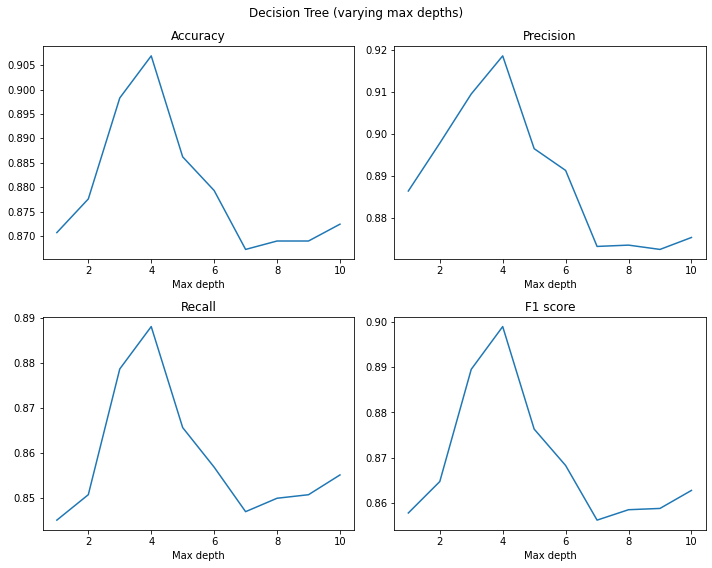

In [109]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Decision Tree (varying max depths)")

ax1.plot(max_depths, accs)
ax1.set_title("Accuracy")
ax1.set_xlabel("Max depth")

ax2.plot(max_depths, precs)
ax2.set_title("Precision")
ax2.set_xlabel("Max depth")

ax3.plot(max_depths, recs)
ax3.set_title("Recall")
ax3.set_xlabel("Max depth")

ax4.plot(max_depths, f1s)
ax4.set_title("F1 score")
ax4.set_xlabel("Max depth")

plt.tight_layout()  # Optional: Adjust the spacing between subplots

plt.savefig('images/dt_max_depths.png')
plt.show()

## For random forest

Varying the number of features with the number of trees fixed

In [91]:
n_feats_list = np.unique(np.logspace(np.log10(1), np.log10(238), num=20, dtype=int))
accs = []
precs = []
recs = []
f1s = []

for n_feats in n_feats_list:
    acc, prec, rec, f1_ = evaluate(RandomForest, X_dev, y_dev, X_val, y_val, args=[5, n_feats], verbose=False)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    print(f'N. feats: {n_feats} done')

N. feats: 1 done
N. feats: 2 done
N. feats: 3 done
N. feats: 4 done
N. feats: 5 done
N. feats: 7 done
N. feats: 10 done
N. feats: 13 done
N. feats: 17 done
N. feats: 23 done
N. feats: 31 done
N. feats: 42 done
N. feats: 56 done
N. feats: 75 done
N. feats: 100 done
N. feats: 133 done
N. feats: 178 done
N. feats: 237 done


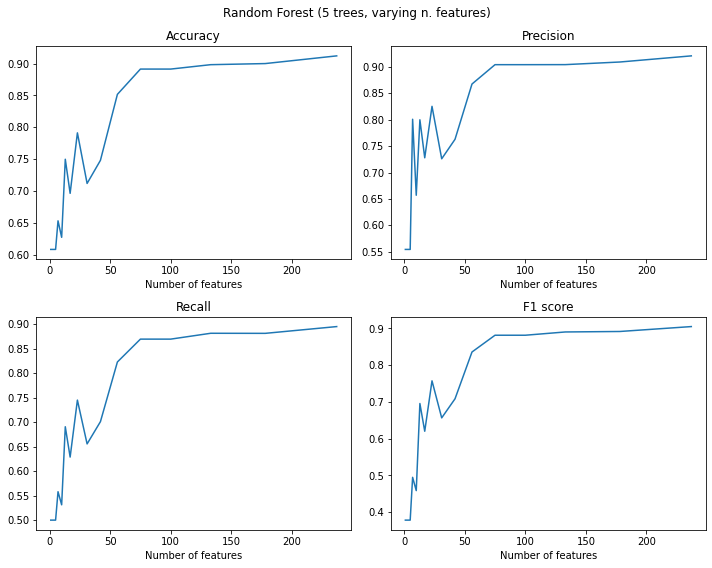

In [92]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Random Forest (5 trees, varying n. features)")

ax1.plot(n_feats_list, accs)
ax1.set_title("Accuracy")
ax1.set_xlabel("Number of features")

ax2.plot(n_feats_list, precs)
ax2.set_title("Precision")
ax2.set_xlabel("Number of features")

ax3.plot(n_feats_list, recs)
ax3.set_title("Recall")
ax3.set_xlabel("Number of features")

ax4.plot(n_feats_list, f1s)
ax4.set_title("F1 score")
ax4.set_xlabel("Number of features")

plt.tight_layout()  # Optional: Adjust the spacing between subplots

plt.savefig('images/rf_n_feats.png')
plt.show()

Varying the number of trees while the number of features fixed

In [93]:
n_trees_list = np.unique(np.logspace(np.log10(1), np.log10(30), num=10, dtype=int))
accs = []
precs = []
recs = []
f1s = []

for n_trees in n_trees_list:
    acc, prec, rec, f1_ = evaluate(RandomForest, X_dev, y_dev, X_val, y_val, args=[n_trees, 150], verbose=False)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    print(f'N. trees: {n_trees} done')

N. trees: 1 done
N. trees: 2 done
N. trees: 3 done
N. trees: 4 done
N. trees: 6 done
N. trees: 9 done
N. trees: 14 done
N. trees: 20 done
N. trees: 29 done


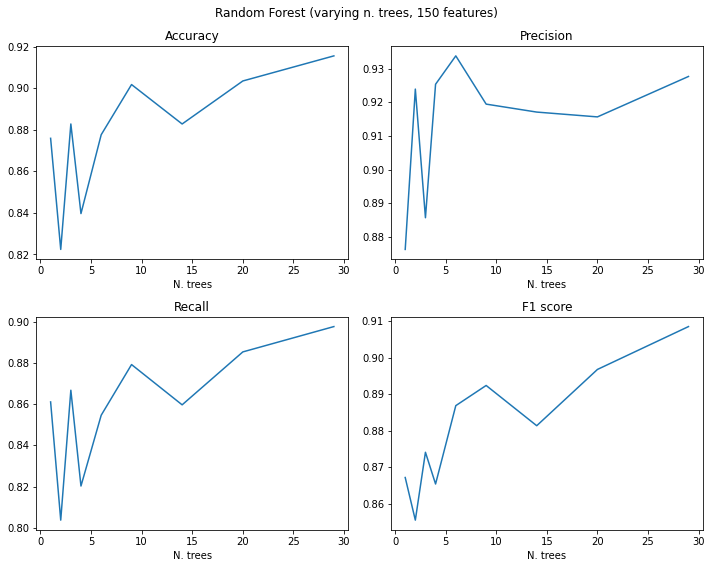

In [94]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Random Forest (varying n. trees, 150 features)")

ax1.plot(n_trees_list, accs)
ax1.set_title("Accuracy")
ax1.set_xlabel("N. trees")

ax2.plot(n_trees_list, precs)
ax2.set_title("Precision")
ax2.set_xlabel("N. trees")

ax3.plot(n_trees_list, recs)
ax3.set_title("Recall")
ax3.set_xlabel("N. trees")

ax4.plot(n_trees_list, f1s)
ax4.set_title("F1 score")
ax4.set_xlabel("N. trees")

plt.tight_layout()  # Optional: Adjust the spacing between subplots

plt.savefig('images/rf_n_trees.png')
plt.show()

N. trees: 1 done
N. trees: 2 done
N. trees: 3 done
N. trees: 4 done
N. trees: 6 done
N. trees: 9 done
N. trees: 14 done
N. trees: 20 done
N. trees: 29 done


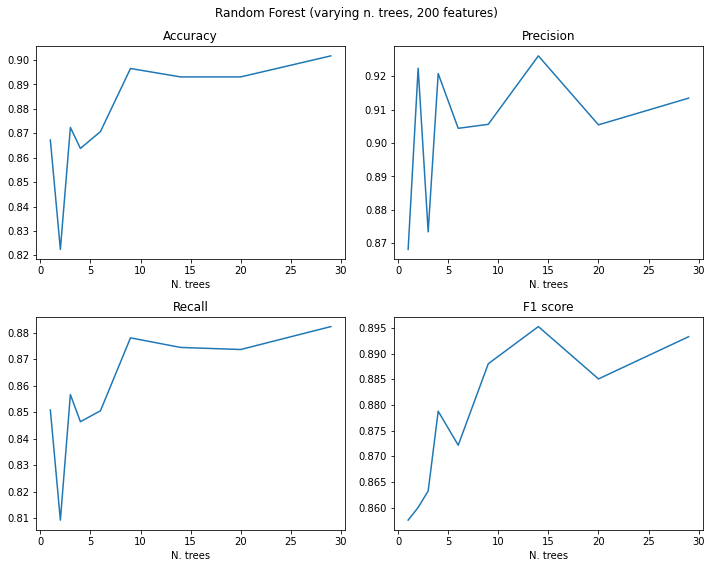

In [95]:
n_trees_list = np.unique(np.logspace(np.log10(1), np.log10(30), num=10, dtype=int))
accs = []
precs = []
recs = []
f1s = []

for n_trees in n_trees_list:
    acc, prec, rec, f1_ = evaluate(RandomForest, X_dev, y_dev, X_val, y_val, args=[n_trees, 200], verbose=False)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    print(f'N. trees: {n_trees} done')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Random Forest (varying n. trees, 200 features)")

ax1.plot(n_trees_list, accs)
ax1.set_title("Accuracy")
ax1.set_xlabel("N. trees")

ax2.plot(n_trees_list, precs)
ax2.set_title("Precision")
ax2.set_xlabel("N. trees")

ax3.plot(n_trees_list, recs)
ax3.set_title("Recall")
ax3.set_xlabel("N. trees")

ax4.plot(n_trees_list, f1s)
ax4.set_title("F1 score")
ax4.set_xlabel("N. trees")

plt.tight_layout()  # Optional: Adjust the spacing between subplots

plt.savefig('images/rf_n_trees2.png')
plt.show()

## For Bagging

In [97]:
n_trees_list = np.unique(np.logspace(np.log10(1), np.log10(20), num=10, dtype=int))
accs = []
precs = []
recs = []
f1s = []

for n_trees in n_trees_list:
    acc, prec, rec, f1_ = evaluate(Bagging, X_dev, y_dev, X_val, y_val, args=[n_trees], verbose=False)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    print(f'N. trees: {n_trees} done')

N. trees: 1 done
N. trees: 2 done
N. trees: 3 done
N. trees: 5 done
N. trees: 7 done
N. trees: 10 done
N. trees: 14 done
N. trees: 20 done


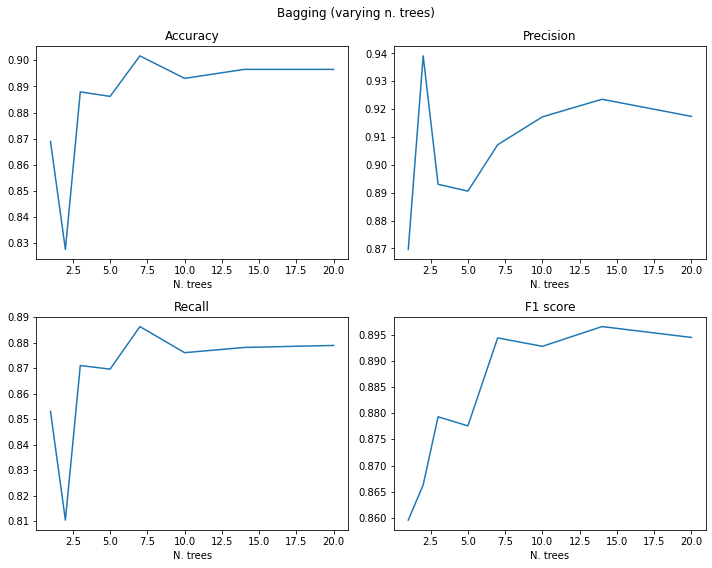

In [98]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Bagging (varying n. trees)")

ax1.plot(n_trees_list, accs)
ax1.set_title("Accuracy")
ax1.set_xlabel("N. trees")

ax2.plot(n_trees_list, precs)
ax2.set_title("Precision")
ax2.set_xlabel("N. trees")

ax3.plot(n_trees_list, recs)
ax3.set_title("Recall")
ax3.set_xlabel("N. trees")

ax4.plot(n_trees_list, f1s)
ax4.set_title("F1 score")
ax4.set_xlabel("N. trees")

plt.tight_layout()  # Optional: Adjust the spacing between subplots

plt.savefig('images/bag_n_trees.png')
plt.show()

# Insights

When trying out Decision Tree with maximum depth equal to one, we observed accuracy reached unusually high value (87%) and the same for F1 score

In [77]:
_ = evaluate(DecisionTree, X_dev, y_dev, X_val, y_val, config=[4, .01, .001, 1])

  Accuracy  : 0.87069
  Precision : 0.88637
  Recall    : 0.84502
  F1        : 0.85774
 Ft. 232 < 4.00 [ n= 2325.0 ]
   => 0.09 [ n= 748.0 ]
   => 0.85 [ n= 1577.0 ]


The above means the first node with split at feature 232 on value 4.0 and before splitting it has a total of 2325 samples. The left child of the node contains 748 samples, 9% of which is positive. Similarly, the right child contains 1577 samples, and 85% of them are positive

The tree achieved remarkable result with just one split on feature 232, which is **Curricular units 2nd sem (approved)**. To test if there is an error somewhere, we test it on a new dataset with only one feature value

In [86]:
n, d = X.shape
X_new = np.zeros((n,1))
X_new = X_train[:, 232].reshape(-1,1) # get the 232th column

X_d, y_d, X_v, y_v = stratified_split(X_new, y_train)
_ = evaluate(DecisionTree, X_d, y_d, X_v, y_v, config=[4, .01, .001, 1])

  Accuracy  : 0.87586
  Precision : 0.88347
  Recall    : 0.85556
  F1        : 0.86536
 Ft. 0 < 4.00 [ n= 2325.0 ]
   => 0.09 [ n= 735.0 ]
   => 0.85 [ n= 1590.0 ]


So feature 232 is the feature that likely indicates whether a student will continue study or dropout in the future. If you continue to do this, you will find the next four important features are:

- Curricular units 1st sem (enrolled) - 224
- Admission grade - 214
- Tuition fees up to date - 218
- Unemployment rate - 235

In [75]:
_ = evaluate(DecisionTree, X_dev, y_dev, X_val, y_val, config=[4, .01, .001, 5])

  Accuracy  : 0.88621
  Precision : 0.89647
  Recall    : 0.86563
  F1        : 0.87632
 Ft. 232 < 4.00 [ n= 2325.0 ]
   Ft. 224 < 1.00 [ n= 748.0 ]
     Ft. 214 < 0.94 [ n= 93.0 ]
       Ft. 218 < 1.00 [ n= 56.0 ]
         => 0.00 [ n= 9.0 ]
         Ft. 235 < 0.85 [ n= 47.0 ]
           => 0.59 [ n= 32.0 ]
           => 0.13 [ n= 15.0 ]
       Ft. 60 < 1.97 [ n= 37.0 ]
         Ft. 235 < 1.45 [ n= 23.0 ]
           => 0.95 [ n= 20.0 ]
           => 0.33 [ n= 3.0 ]
         Ft. 82 < 1.00 [ n= 14.0 ]
           => 0.78 [ n= 9.0 ]
           => 0.00 [ n= 5.0 ]
     Ft. 232 < 2.00 [ n= 655.0 ]
       => 0.00 [ n= 487.0 ]
       Ft. 226 < 5.00 [ n= 168.0 ]
         Ft. 219 < 1.00 [ n= 126.0 ]
           => 0.15 [ n= 54.0 ]
           => 0.00 [ n= 72.0 ]
         Ft. 218 < 1.00 [ n= 42.0 ]
           => 0.00 [ n= 12.0 ]
           => 0.47 [ n= 30.0 ]
   Ft. 218 < 1.00 [ n= 1577.0 ]
     Ft. 232 < 6.00 [ n= 79.0 ]
       Ft. 37 < 1.00 [ n= 49.0 ]
         => 0.00 [ n= 42.0 ]
         Ft. 61

# Evaluation

In [ ]:
evaluate(DecisionTree, X_train, y_train, X_test, y_test, config=[4, .01, .001, 5])

In [101]:
evaluate(RandomForest, X_train, y_train, X_test, y_test, args=[10, 150])

  Accuracy  : 0.89241
  Precision : 0.91124
  Recall    : 0.87835
  F1        : 0.89276


(0.8924137931034483,
 0.9112440604495954,
 0.8783454696221694,
 0.8927612607903873)

In [102]:
evaluate(RandomForest, X_train, y_train, X_test, y_test, args=[5, 200])

  Accuracy  : 0.89379
  Precision : 0.89311
  Recall    : 0.88261
  F1        : 0.88714


(0.8937931034482759,
 0.8931091058011067,
 0.8826131391308734,
 0.8871421957569221)

# Inference

In [54]:
rf_clf = RandomForest(num_trees=5, num_features=200)
rf_clf.fit(X_train, y_train)

In [55]:
id = 123

print('(Graduated: 1.0, Dropout: -1.0)')
print('- Prediction :', rf_clf.predict(X_test[id,:].reshape(1,-1))[0][0])
print('- Actual     :', y_test[id][0])

(Graduated: 1.0, Dropout: -1.0)
- Prediction : -1.0
- Actual     : -1.0


# Save model

**Notes:** Class DTNode, DecisionTree, Bagging, RandomForest must be defined in the same space where 'load_model' is called

In [17]:
import pickle

def save_model(obj, file_path):
    """
    Save an object to a file using pickle.

    Parameters:
    obj (object): The object to be saved.
    file_path (str): The path to the file where the object will be saved.
    """
    try:
        with open(file_path, 'wb') as file:
            pickle.dump(obj, file)
        print("Object saved successfully.")
    except Exception as e:
        print(f"Error occurred while saving the object: {str(e)}")

def load_model(file_path):
    """
    Load an object from a file using pickle.

    Parameters:
    file_path (str): The path to the file containing the object.

    Returns:
    object: The loaded object.
    """
    try:
        with open(file_path, 'rb') as file:
            obj = pickle.load(file)
        print("Object loaded successfully.")
        return obj
    except Exception as e:
        print(f"Error occurred while loading the object: {str(e)}")
        return None


In [58]:
save_model(rf_clf, 'randomforest.pkl')

Object saved successfully.


In [18]:
clf = load_model('randomforest.pkl')

id = 123
print('(Graduated: 1.0, Dropout: -1.0)')
print('- Prediction :', clf.predict(X_test[id,:].reshape(1,-1))[0][0])
print('- Actual     :', y_test[id][0])

Object loaded successfully.
(Graduated: 1.0, Dropout: -1.0)
- Prediction : -1.0
- Actual     : -1.0
